# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from matplotlib.patches import Patch

# Set constants

In [2]:
# set figure details
figsize = (10, 10)
dpi = 200

# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load data

In [4]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "is_healthy.csv"), index_col=[0, 1])
phenotype = pd.read_csv(os.path.join(config.CLEAN_DIR, "phenotype.csv"), index_col=[0, 1])
GMHI2_scores_ISV = pd.read_csv(os.path.join(config.PREDICTION_DIR, "GMHI2_scores_ISV.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_ISV.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283245        0.106067                     0.106067   
         SAMN03283294        0.000000                     0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283245                                            0.106067   
         SAMN03283294                                            0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283245                                               0.106067                      
         SAMN03283294                                               0.000000                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283245                                               0.106067                                             
         SAMN03283294                                               0.000000                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283245                                               0.072453                                                                   
         SAMN03283294                                               0.000000                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283245                              True
         SAMN03283294                              True

GMHI2_ISV
Study_ID Sample Accession           
GMHI-10  SAMN03283239       1.876379
         SAMN03283266       0.273884
         SAMN03283281       0.942891
         SAMN03283245       1.152237
         SAMN03283294       2.140906

In [5]:
studies = np.unique(X.index.get_level_values(0))
studies

array(['GMHI-10', 'GMHI-11', 'GMHI-13', 'GMHI-14', 'GMHI-15', 'GMHI-17',
       'GMHI-2', 'GMHI-21', 'GMHI-23', 'GMHI-24', 'GMHI-26', 'GMHI-27',
       'GMHI-28', 'GMHI-3', 'GMHI-31', 'GMHI-32', 'GMHI-33', 'GMHI-4',
       'GMHI-5', 'GMHI-9', 'GMHI-V-35', 'GMHI-V-36', 'GMHI-V-38',
       'GMHI-V-40', 'GMHI-V-41', 'P11', 'P110', 'P121', 'P132', 'P135',
       'P140', 'P15', 'P17', 'P2', 'P21', 'P24', 'P32', 'P34', 'P39',
       'P48', 'P53', 'P56', 'P57', 'P69', 'P74', 'P77', 'P8', 'P80',
       'P81', 'P87', 'P88', 'P89', 'P9', 'P94', 'P95', 'P96', 'P98'],
      dtype=object)

In [18]:
def get_info(cutoff):
    info = pd.DataFrame((GMHI2_scores_ISV > 0).values, index=GMHI2_scores_ISV.index, columns=["predicted"])
    info["phenotype"] = phenotype
    info["y"] = y


    # remove samples with low GMHI2 score magnitudes
    info = info[(abs(GMHI2_scores_ISV) >= cutoff).values]
    return info

In [50]:
def get_precision_recall_scores(info):
    dicts = []
    for study in studies:
        study_df = info.loc[study] 
        study_phenotypes = np.unique(study_df["phenotype"])

        # only evaluate case control studies
        if study_phenotypes.shape[0] != 2 or "Healthy" not in study_phenotypes:
            continue

        case_phenotype = study_phenotypes[0] if study_phenotypes[0] != "Healthy" else study_phenotypes[1]

        precision_control = precision_score(study_df["y"], study_df["predicted"])    
        recall_control = recall_score(study_df["y"], study_df["predicted"])    

        precision_case = precision_score(~study_df["y"], ~study_df["predicted"])    
        recall_case = recall_score(~study_df["y"], ~study_df["predicted"])    

        dicts.append({
            "study_and_phenotype" : f"{study} Healthy",  
            "precision" : precision_control,
            "recall" : recall_control,
            "n" : study_df["y"].sum()
        })

        dicts.append({
            "study_and_phenotype" : f"{study} {case_phenotype}",  
            "precision" : precision_case,
            "recall" : recall_case,
            "n" : (~study_df["y"]).sum()
        })
    df = pd.DataFrame(dicts)
    df = df.set_index("study_and_phenotype")
    return df

In [61]:
def plot_bars(cutoff):
    filename = f"performance_per_singular_case_vs_control_cutoff={cutoff}.svg"
    fig, axes = plt.subplots(figsize=figsize, ncols=2, sharey=True, dpi=dpi)

    fig.tight_layout()
    
    info = get_info(cutoff)
    df = get_precision_recall_scores(info)
    colors = [healthy_color, nonhealthy_color] * (df.shape[0] // 2)

    # display average precision and recall for control and case
    healthy_idx = np.array(["Healthy" in ind for ind in df.index])
    control = df.iloc[healthy_idx]
    case = df.iloc[~healthy_idx]
    means = pd.concat([control.iloc[:, :2].mean(), case.iloc[:, :2].mean()], axis=1)
    means.columns = ["control", "case"]
    means.loc["# of samples"] = [df.iloc[healthy_idx]["n"].sum(), df.iloc[~healthy_idx]["n"].sum()]
    display(means)
    
    axes[0].barh(df.index, df["precision"], align='center', color=colors)
    axes[0].set_xlabel("Precision", fontsize=18)
    axes[0].invert_xaxis() 

    axes[1].barh(df.index, df["recall"], align='center', color=colors)
    axes[1].set_xlabel("Recall", fontsize=18)
    axes[1].tick_params(left=False)

    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(linestyle = '--', axis="x")

    handles = [
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Case", alpha=1),
        Patch(facecolor=healthy_color, edgecolor="k", label="Control", alpha=1),
    ]

    # draw mean lines
    axes[0].axvline(means["control"].loc["precision"], linestyle="--", c=healthy_color)
    axes[0].axvline(means["case"].loc["precision"], linestyle="--", c=nonhealthy_color)
    axes[1].axvline(means["control"].loc["recall"], linestyle="--", c=healthy_color)
    axes[1].axvline(means["case"].loc["recall"], linestyle="--", c=nonhealthy_color)


    plt.legend(handles=handles, prop={'size': 14}, loc=0, handlelength=1.4, handleheight=1.4)

    plt.subplots_adjust(wspace=0)
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

,control,case
precision,0.607130,0.664482
recall,0.441589,0.763551
# of samples,1100.000000,1651.000000


,control,case
precision,0.618620,0.671633
recall,0.424273,0.787333
# of samples,1014.000000,1584.000000


/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,control,case
precision,0.625041,0.762589
recall,0.409006,0.859777
# of samples,363.000000,868.000000


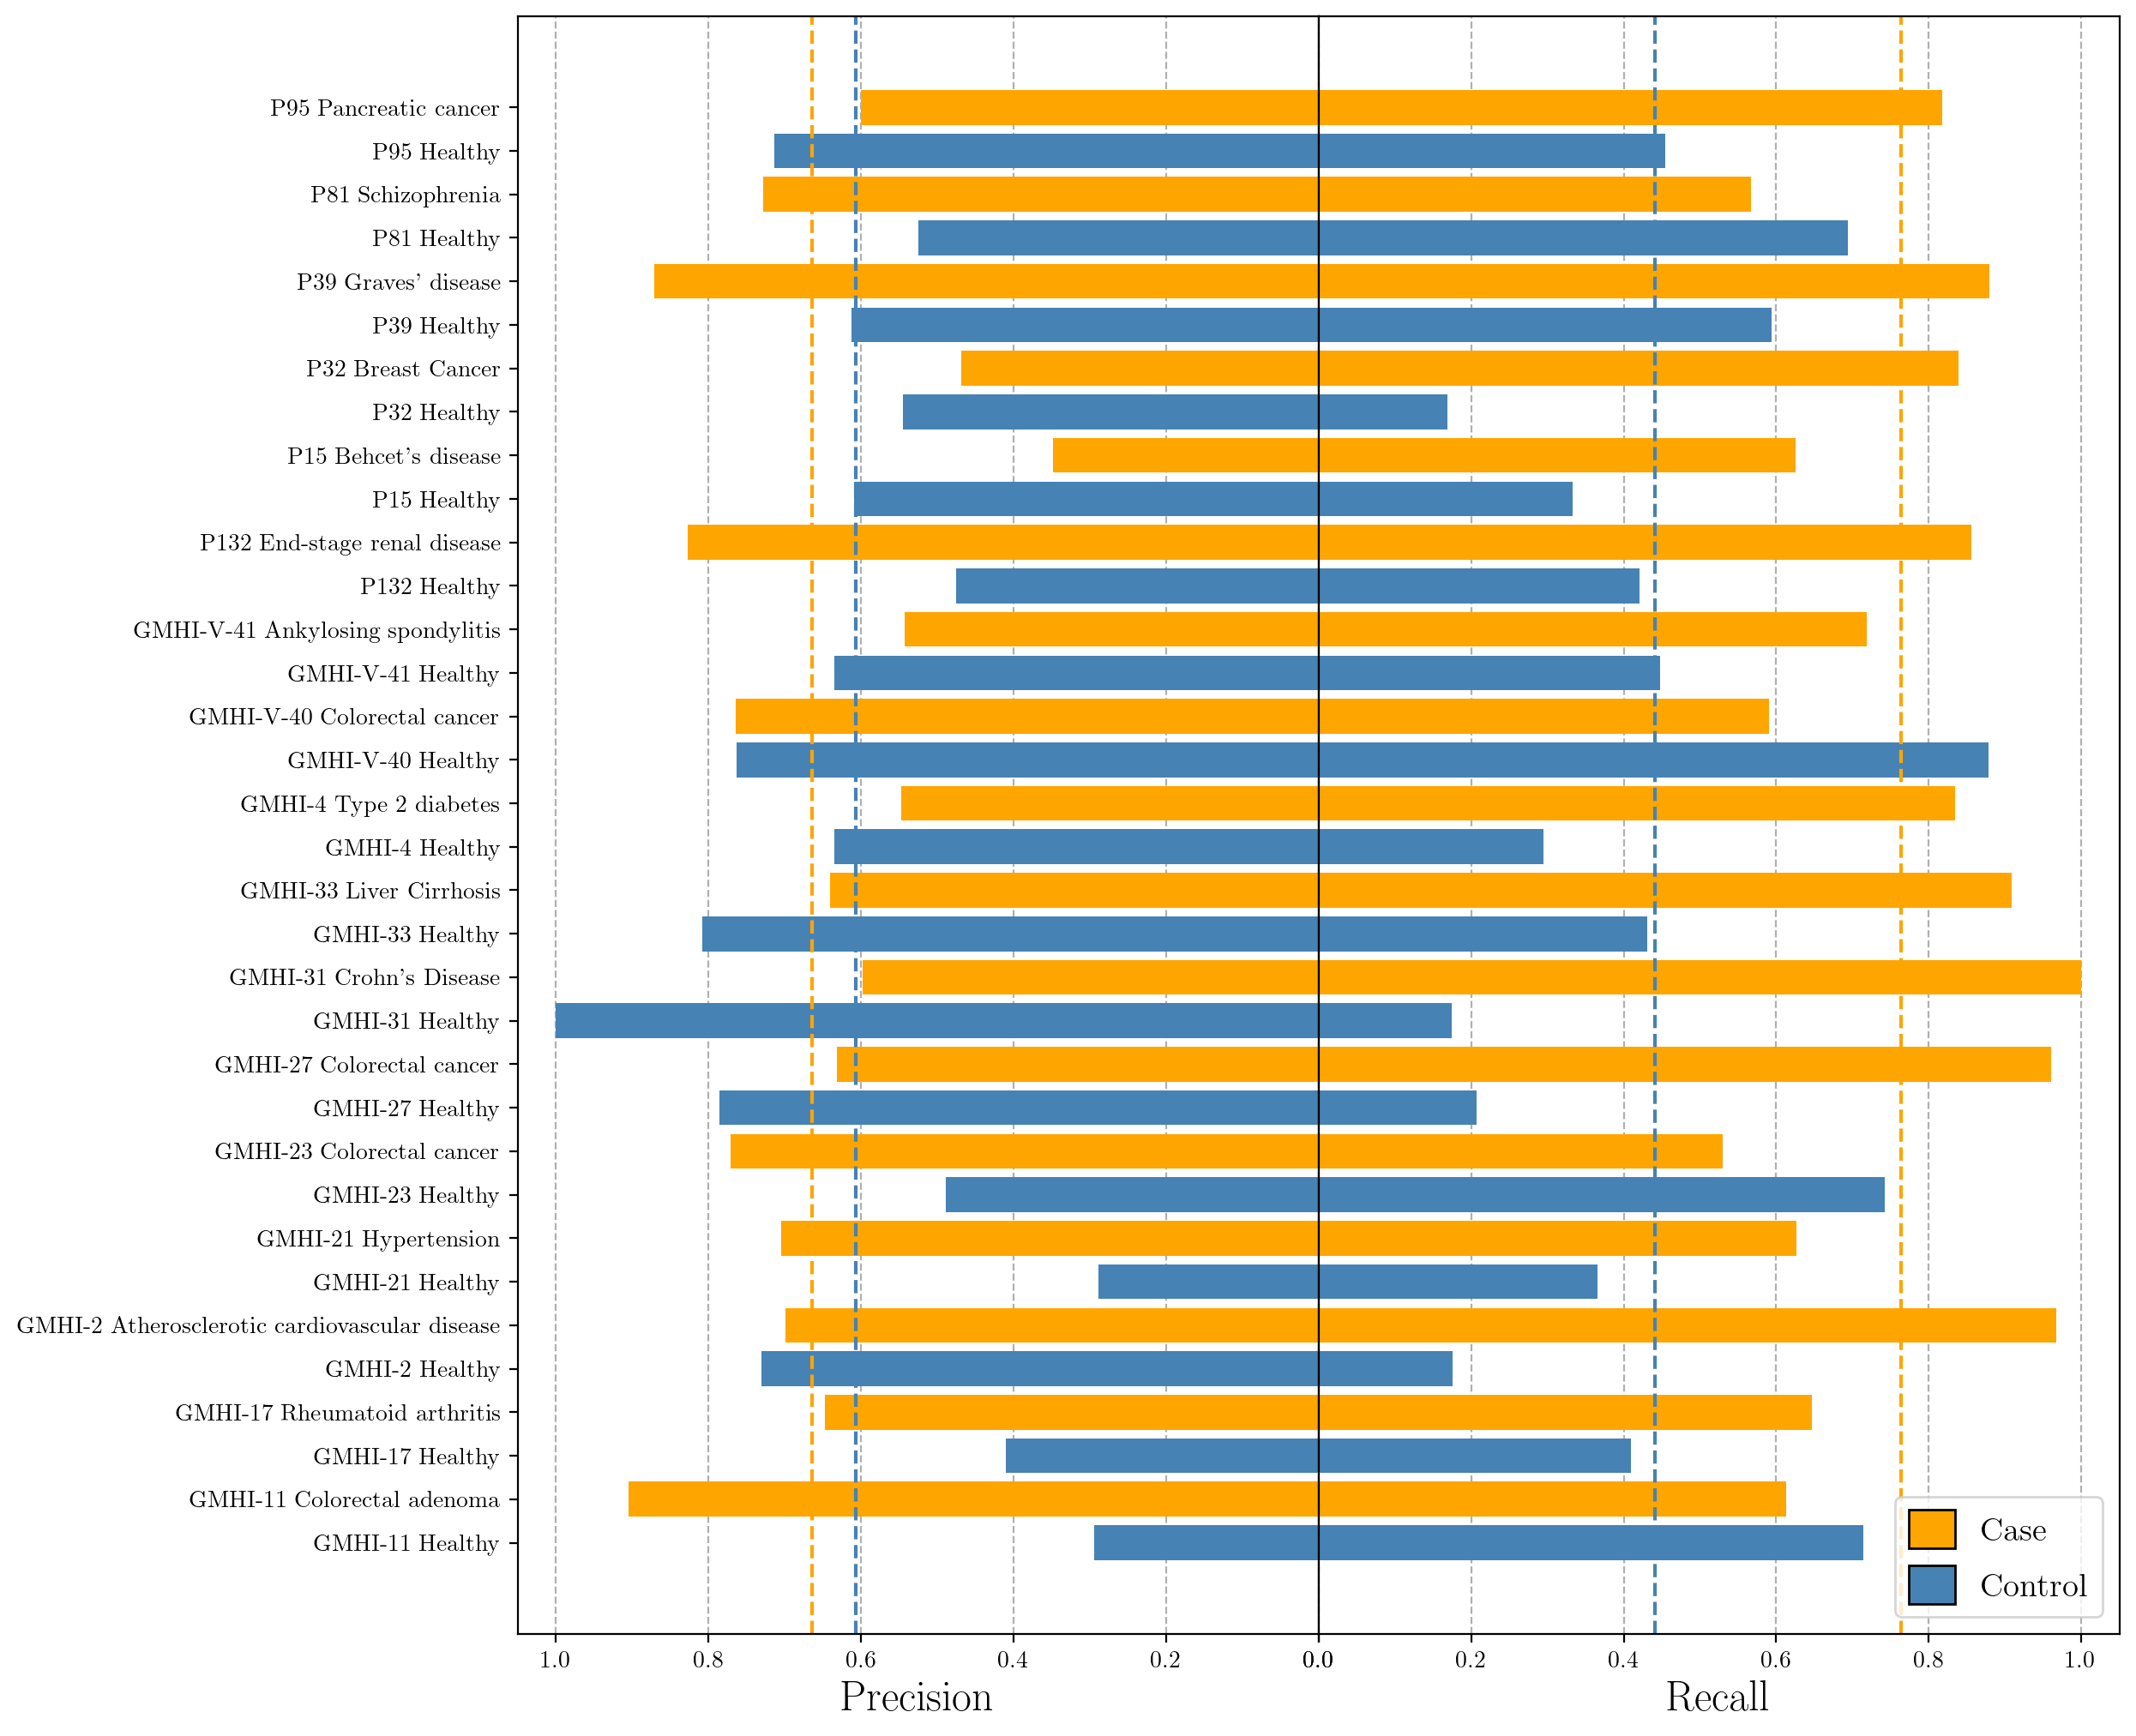

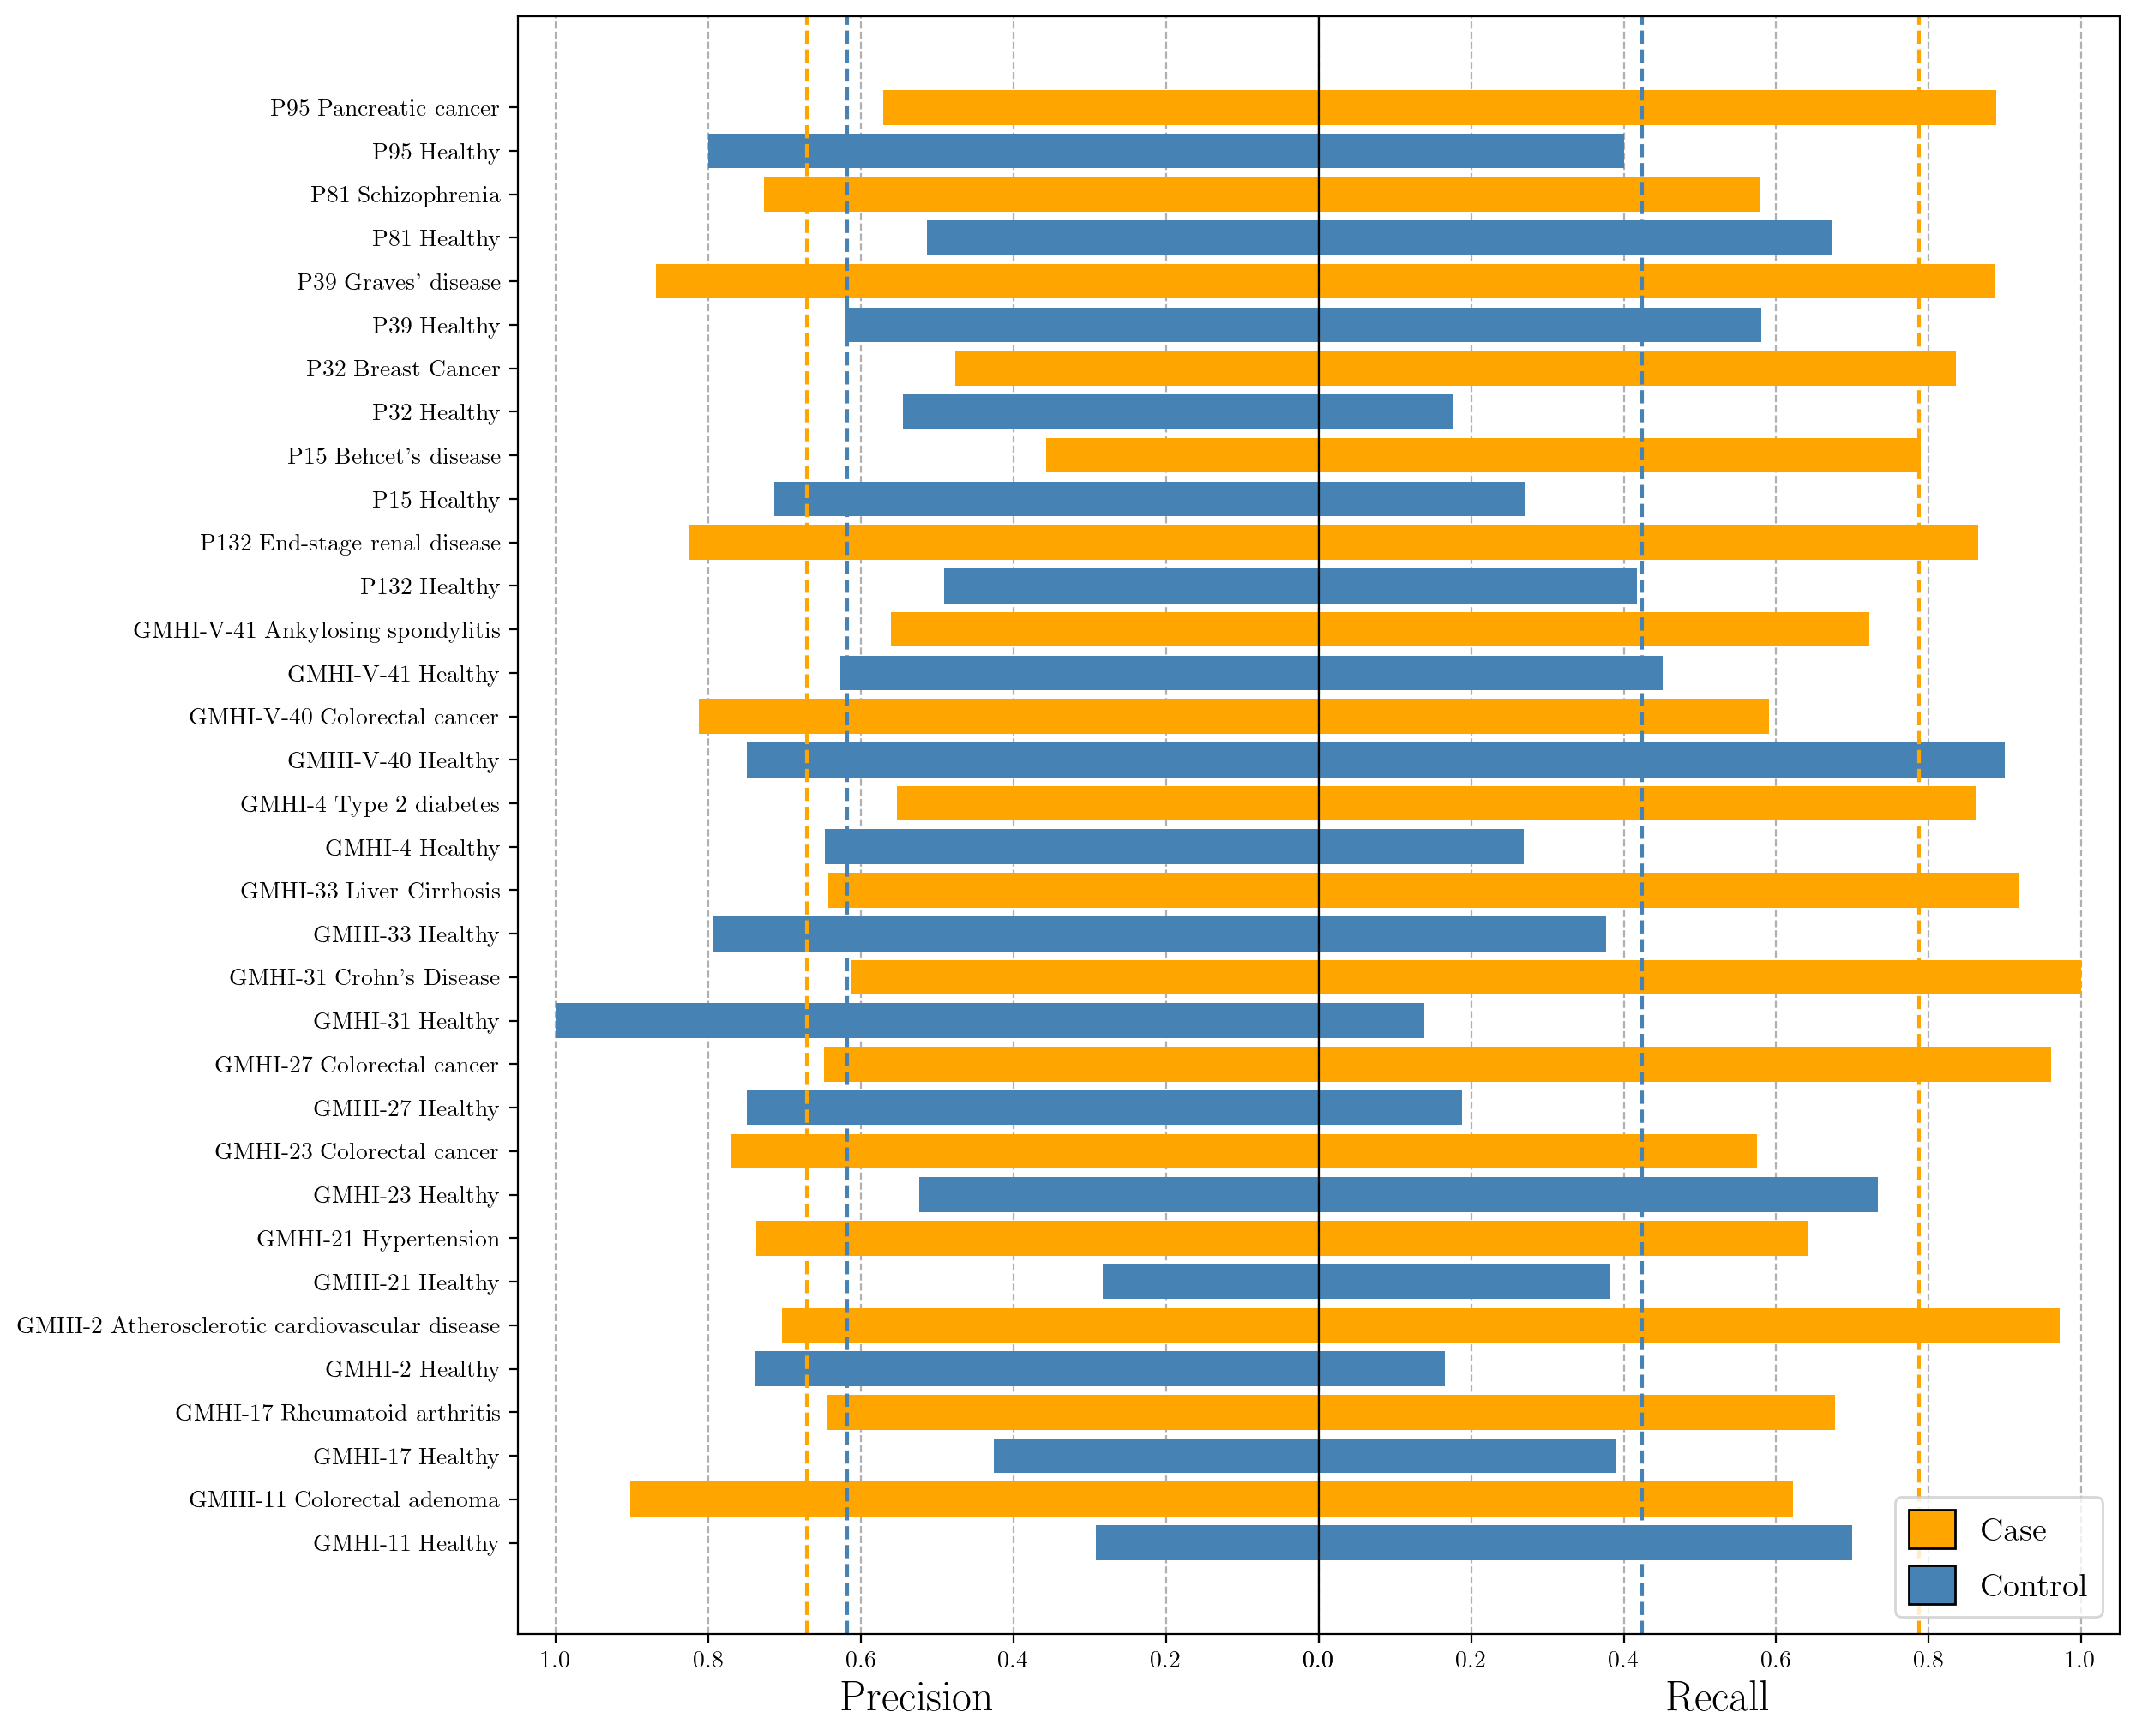

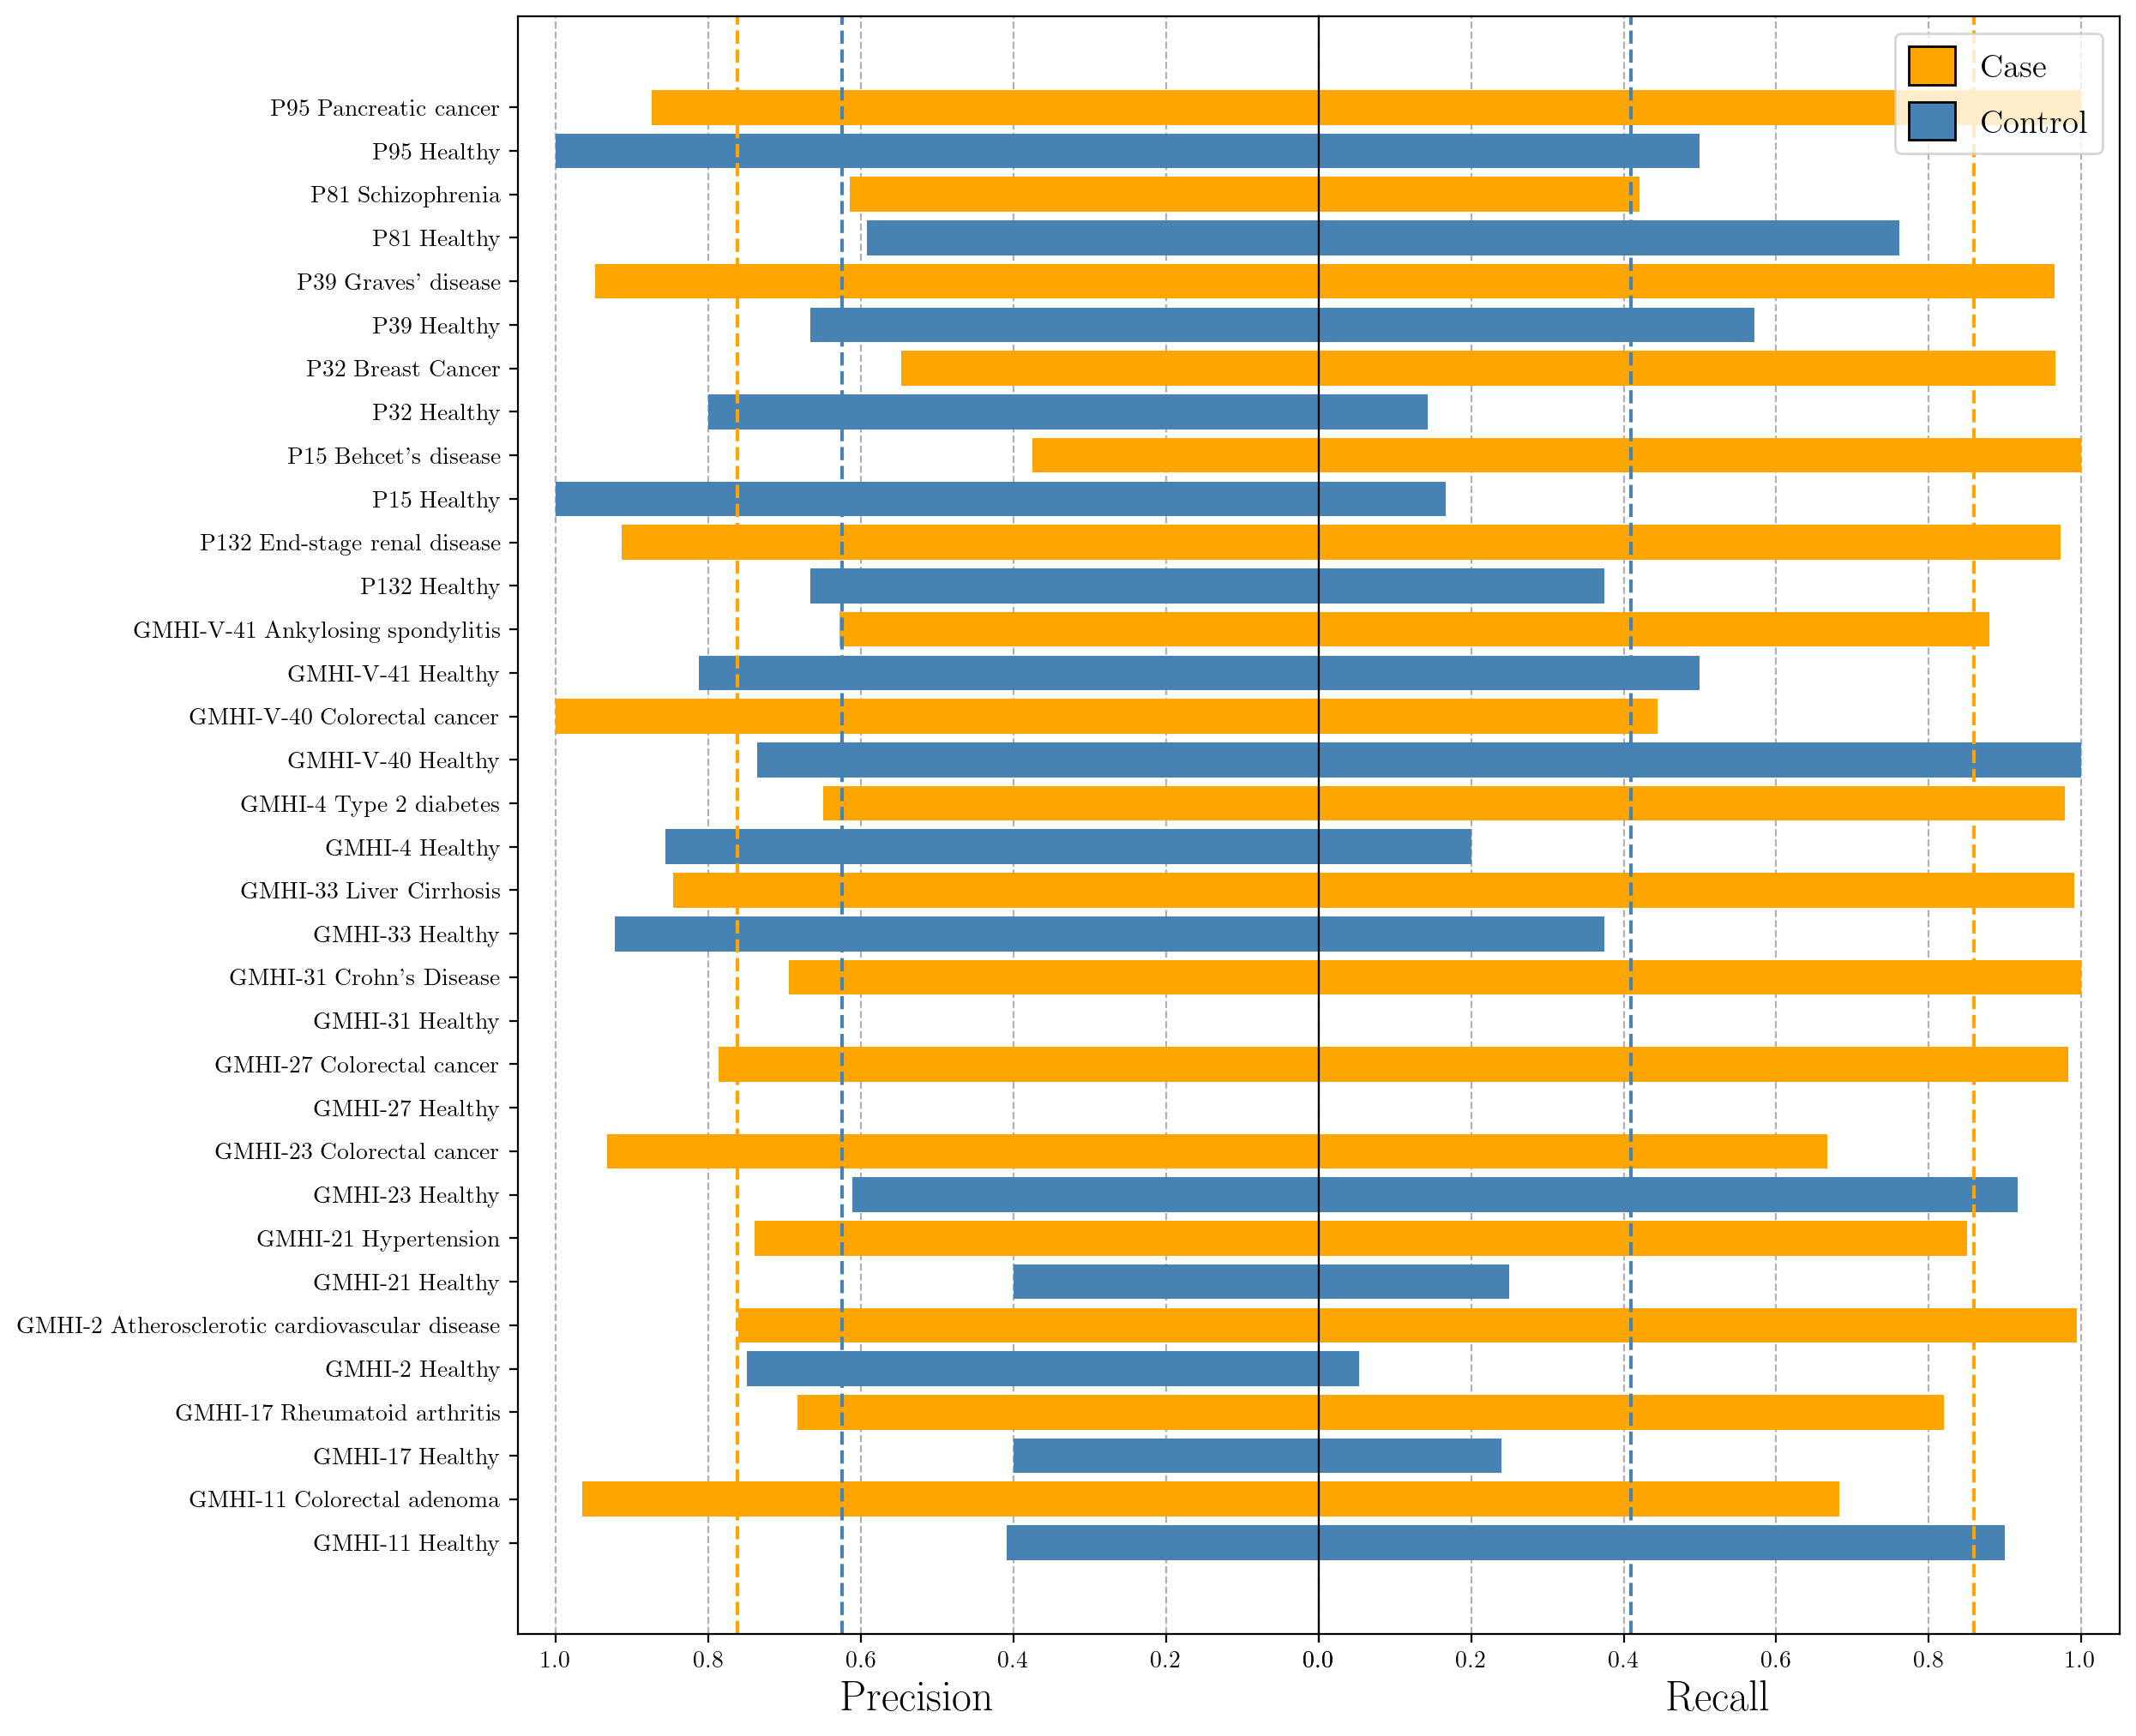

In [62]:
plot_bars(0)
plot_bars(0.1)
plot_bars(1)